# 2η Εργαστηριακή Άσκηση

## Παραδοτέο 1

Αρχικά φορτώνουμε τις βιβλιοθήκες που θα χρησιμοποιήσουμε

In [1]:
import random
random.seed(2016) 
from simple_markov_chain_lib import markov_chain
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import math

%matplotlib inline

Έπειτα θα χρησιμοποιήσουμε τις δύο παρακάτω βοηθητικές συναρτήσεις

In [2]:
def create_chain(prob):
    p = prob
    q = 1-p
    init_probs = {"0-0": 1.0} 
    markov_table = {  "0-0": { "15-0": p,  "0-15":q}, 
                     "0-15": {"15-15": p,  "0-30":q}, 
                     "0-30": {"15-30": p,  "0-40":q}, 
                     "0-40": {"15-40": p, "GameB":q}, 
                     "15-0": { "30-0": p, "15-15":q}, 
                    "15-15": {"30-15": p, "15-30":q},
                    "15-30": {"Deuce": p, "15-40":q}, 
                    "15-40": { "AdvB": p, "GameB":q},
                     "30-0": { "40-0": p, "30-15":q}, 
                    "30-15": {"40-15": p, "Deuce":q},
                     "40-0": {"GameA": p, "40-15":q}, 
                    "40-15": {"GameA": p,  "AdvA":q}, 
                    "Deuce": { "AdvA": p,  "AdvB":q},
                     "AdvB": {"Deuce": p, "GameB":q}, 
                     "AdvA": {"GameA": p, "Deuce":q}, 
                    "GameA": {"GameA": 1.0}, 
                    "GameB": {"GameB": 1.0} }
    mc = markov_chain(markov_table, init_probs)
    return mc

def tenis_game(p, N, M):
    mc = create_chain(p)
    phats = []
    steps = 50 #αριθμός σερβίς μετά από τα οποία ελέγχω το αποτέλεσμα
    for m in range(M): #επανάληψη για κάθε session
        counter = 0    #αρχικοποίηση του μετρητή νικών
        for n in range(N):    #για επανάληψη παιχνιδιού
            mc.start()        #αρχικοποίηση της κατάστασης
            for s in range(steps):   #για κάθε σερβίς
                mc.move()            #μετακίνηση σε μία πιθανή κατάσταση
            if mc.running_state=="GameA": counter+=1  #εαν κέρδισε ο Α αύξησε τον counter
        phats.append(counter/N)
    return stat.mean(phats), stat.variance(phats)

Στη συνέχεια θα κάνουμε τον υπολογισμό των εκτιμητριών της πιθανότητας να κερδίσει ο παίκτης που έχει το σερβις, αποθηκεύοντας τις τιμές στο array means.

In [3]:
pr = np.arange(0.02, 0.98, 0.02)
means = []
stds = []
for p in pr:
    m, s = tenis_game(p, 200, 50)
    means.append(m)
    stds.append(s)
means = np.array(means)

Στο παρακάτω παράθυρο εμφανίζουμε τα αποτελέσματα, μαζί με μια σιγμοειδή συνάρτηση η οποία φαίνεται να την ακολουθεί αρκετά καλά.

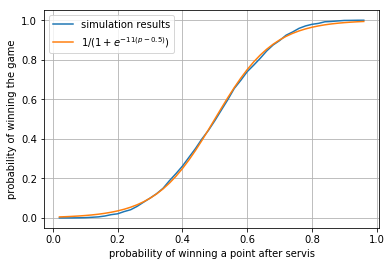

In [4]:
plt.plot(pr, means.T, label="simulation results")
plt.xlabel("probability of winning a point after servis")
plt.ylabel("probability of winning the game")
plt.grid(True)

# το παρακάτω δεν ζητείται αλλά αξίζει να σημειωθεί
plt.plot(pr, 1/(1+np.exp(-11*(pr-0.5))), label="$1/(1+e^{-11(p-0.5)})$")
plt.legend()
pass

Η παραπάνω γραφική έχει τη μορφή της σιγμοειδούς συνάρτησης $1/(1+e^{-a(x-0.5)})$, όπου εμπειρικά παρατηρήθηκε αρκετά καλή προσαρμογή για $a=11$ (φυσικά θα μπορούσαμε να βρούμε το κατάλληλο $a \in R$ με gradient descent ώστε να ελαχιστοποιείται το ελάχιστο τετραγωνικό σφάλμα). Όταν η πιθανότητα $p$ τείνει στο μηδέν, τότε η πιθανότητα να κερδηθεί το game τείνει κ αυτή στο μηδέν αρκετά πιο γρήγορα, αντίστοιχα όταν η πιθανότητα $p$ τείνει στη μονάδα, τότε και η πιθανότητα να κερδηθεί το game τείνει στη μονάδα (αλλα και πάλι με μεγαλύτερη ταχύτητα). Η σχέση αρχικά είναι κυρτή, στο τέλος είναι κοίλη, ωστόσο στο ενδιάμεσο παρατηρείται γραμμικότητα.

*Εδώ να αναφέρω το εξής: Εκτελώντας τον κώδικα και χρησιμοποιώντας την μαρκοβιανή αλυσίδα όπως την είχα υλοποιήσει στην προηγούμενη εργαστηριακή άσκηση, η σιγμοειδής καμπύλη φαινόταν να επιστρέφει biased αποτελέσματα υπερ του παίκτη 1, καθώς δεν περνούσε κοντά από το (0.5, 0,5) αλλά κοντά από το (0.5, 0.6). Κοιτώντας πιο αναλυτικά τον κώδικα του markov table, διαπίστωσα ότι η μετάβαση από το state "0-15" εμπεριείχε κάποιο λάθος. Η παραπάνω καμπύλη λοιπόν αποδείχτηκε κατάλληλη και για debuging της προηγούμενης εργαστηριακής άσκησης ως προς την εγκυρότητα των αποτελεσμάτων. Δυστυχώς κάτι τετοιο δεν παρατηρήθηκε εμπρόθεσμα.*

## Παραδοτέο 2

Στο παρακάτω κελί ορίζεται και αρχικοποιείται η μαρκοβιανή αλυσίδα

In [5]:
# Transition Table
markov_table = {
    0: {1: .5, 2: .5},  # from state 0 we move to state 1 with prob 0.5 and to state 2 with 0.5
    1: {0: 1/3, 3: 2/3},
    2: {2: 1.},
    3: {0: .5, 3: .25, 4: .25},
    4: {4: 1.}
}

# Initial Distribution
init_dist = {0: 1.}  # we start from state 0 with probability 1

mc = markov_chain(markov_table, init_dist)

Έπειτα δημιουργούνται δύο βοηθητικές συναρτήσεις. Η *timetest()* δέχεται ως όρισμα το sample_size και επιστρέφει την μια εκτίμηση. Η *Mtimest()* δέχεται ως ορίσματα το Μ και το sample_size, και καλώντας Μ-φορές την *timest()* επιστέφει την διασπορά των αποτελεσμάτων.

In [6]:
def timest(sample_size):
    running_total = 0
    for i in range(sample_size):
        mc.start()
        while mc.running_state != 2 and mc.running_state != 4:
            mc.move()
        running_total += mc.steps  # steps it took to be absorbed
    mc_estimate = running_total / sample_size
    return mc_estimate

def Mtimest(M, sample_size):
    t = []
    for i in range(M):
        print
        t.append(timest(sample_size))
    return np.var(np.array(t))

Παρακάτω δημιουργούμε την λίστα των sample_sizes, και την λίστα που θα αποθηκεύσουμε τις εκτιμώμενες διασπορές. Για κάθε sample_size καλούμε την *Mtimest()* και αποθηκεύουμε την διασπορά στην λίστα. Έπειτα μετατρέπουμε τις λίστες σε arrays (αυτό δεν χρειάζεται για το plot αλλά γενικώς είναι καλύτερα να δουλεύουμε με numpy arrays). Απεικονίζουμε τα γραφήματα σε κανονική και σε διπλή λογαριθμική κλίμακα. Στην λογαριθμική κλίμακα όπως φαίνεται παρακάτω η σχέση φαίνεται να είναι γραμμική και γι'αυτό υπολογίζουμε και απεικονίζουμε και την ευθεία ελαχίστων τετραγώνων. Περαιτέρω ανάλυση στο επόμενο Markdown.

The coefficient of the best-fit line is -0.986, which is very close to -1


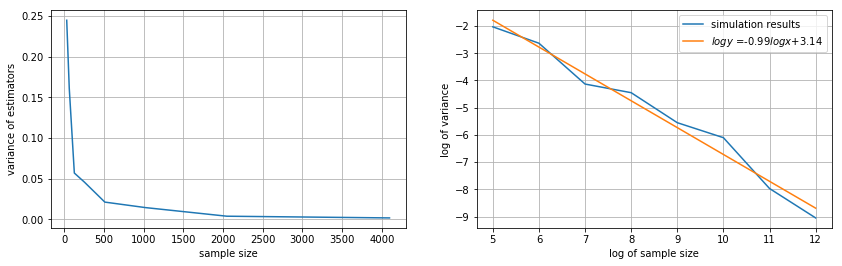

In [7]:
### simulations section ####
sample_sizes = []
for i in range(5, 12+1):
    sample_sizes.append(2**i) #create sample_sizes list

Vars = []
for sample_size in sample_sizes:
    Vars.append(Mtimest(30, sample_size)) #simulate and return variances for all sample_size values

sample_sizes = np.array(sample_sizes) #convert to arrays...it's better
Vars = np.array(Vars)

logx = np.log2(sample_sizes)
logy = np.log2(Vars)
coefs = np.polyfit(logx, logy, 1)



#### plots section #####
plt.figure(figsize=(14, 4)) #figure size for nice visualization

plt.subplot(1,2,1) #for linear axis
plt.plot(sample_sizes, Vars)
plt.xlabel("sample size")
plt.ylabel("variance of estimators")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(logx, logy, label="simulation results")
plt.plot(logx, coefs[1]+logx*coefs[0], label="$logy$ ="+str(np.around(coefs[0],2))+ "$logx$+" + str(np.around(coefs[1], 2)))
plt.xlabel("log of sample size")
plt.ylabel("log of variance")
plt.legend()
plt.grid(True)

print("The coefficient of the best-fit line is {0:.3f}, which is very close to -1".format(coefs[0]))
pass

Βρίσκοντας τους συντελεστές της σχέσης $logy=\alpha logx + \beta$ μπορούμε να αντιστέψουμε την λογαρίθμιση. Με βάση λογαρίθμου το 2 θα έχουμε: $2^{logy}=2^{\alpha logx + \beta}$ άρα $y=2^{\beta}x^{\alpha}$. Συνεπώς με βάση τις παραπάνω σχέσεις όπυυ $\alpha \approx-1$ εξάγουμε το συμπέρασμα ότι η διασπορά του εκτιμητή θα είναι αντιστρόφως ανάλογη του πλήθους των δειγμάτων, πολλαπλσιαμένη με μια σταθερά.

Αυτό επιβεβαιώνεται και από την θεωρία. Υπενθυμίζουμε ότι $Var(nX)=n^2Var(X)$ ενώ $Var(X_1+X_2+...+X_n)=nVar(X)$. Έτσι για μια τυχαία μεταβλητή $Y=\frac{X_1+X_2+...+X_n}{n}$ θα έχουμε ότι $Var(Y)=\frac{1}{n^2}Var(X_1+X_2+...+X_n)$ άρα $Var(Y)=\frac{1}{n}Var(X)$ δηλαδή αντιστρόφως ανάλογη του πλήθους των δειγμάτων. 